In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.head()

,id,name,age,release_date,developer,price,free to play,Arabic,Bulgarian,Chinese (Simplified),...,Skiing,Snowboarding,Well-Written,Hardware,8-bit Music,BMX,Steam Machine,Reboot,num_tags,time_delta
0,830580,BattleBeasts,0,2021-05-10,Oleg Shestoperov,4.99,0,0,0,0,...,0,0,0,0,0,0,0,0,17,98
1,251590,Soul Saga,0,2020-02-28,Disastercake,14.99,0,0,0,0,...,0,0,0,0,0,0,0,0,20,535
2,914230,Swamp Jump,0,2018-08-21,Bullid Games,1.99,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1091
3,877260,Retro Snake,0,2018-06-20,"Flying potato bread, Wixl",1.99,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1153
4,893140,Gold Digger Maze,0,2018-07-24,Bullid Games,3.99,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1119


In [24]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 466 columns):
 #    Column                             Dtype  
---   ------                             -----  
 0    id                                 int64  
 1    name                               object 
 2    age                                int64  
 3    release_date                       object 
 4    developer                          object 
 5    price                              float64
 6    free to play                       int64  
 7    Arabic                             int64  
 8    Bulgarian                          int64  
 9    Chinese (Simplified)               int64  
 10   Chinese (Traditional)              int64  
 11   Czech                              int64  
 12   Danish                             int64  
 13   Dutch                              int64  
 14   English                            int64  
 15   Finnish                            int64  
 16   French

In [4]:
y = df.price

#only taking values, where we don't have a zero count across all observations
X = df.drop(columns = ['price', 'id', 'name', 'release_date', 'free to play']).loc[:, (df != 0).any(axis=0)]

# Transform to category
#X['developer'] = X['developer'].astype('str').astype('category').cat.codes



In [5]:
# Transform to category
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
X['developer'] = LE.fit_transform(X['developer'])

(array([594.,   0.,   0.,   0.,   0.,   3.,   0.,  10.,   0.,  29.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

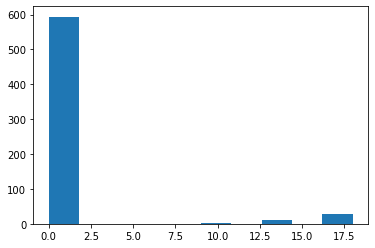

In [6]:
# Probably drop this feature?
plt.hist(X['age'])

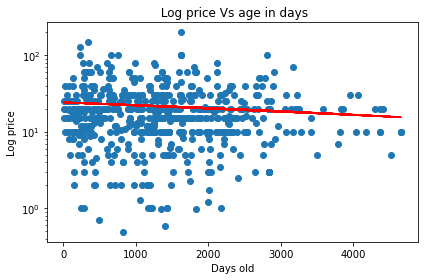

In [7]:
fig = plt.figure()
plt.yscale('log')
plt.title(' Log price Vs age in days')
plt.xlabel('Days old')
plt.ylabel('Log price')
plt.scatter(X['time_delta'], y)
m, b = np.polyfit(X['time_delta'], y, 1)
plt.plot(X['time_delta'], m*X['time_delta'] + b, color = 'red')
fig.tight_layout()

(array([436., 140.,  39.,  11.,   7.,   0.,   1.,   1.,   0.,   1.]),
 array([  0.49,  20.44,  40.39,  60.34,  80.29, 100.24, 120.19, 140.14,
        160.09, 180.04, 199.99]),
 <BarContainer object of 10 artists>)

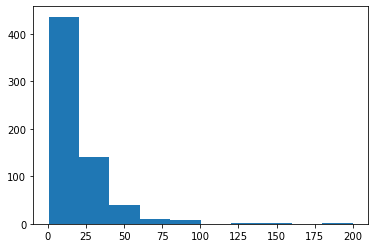

In [8]:
plt.hist(y)

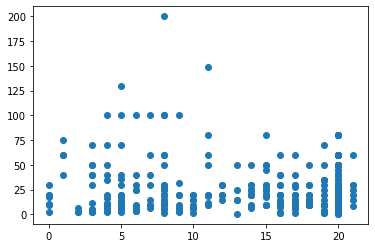

In [9]:
# number of tags against price
plt.scatter(x = 'num_tags', y='price', data = df)

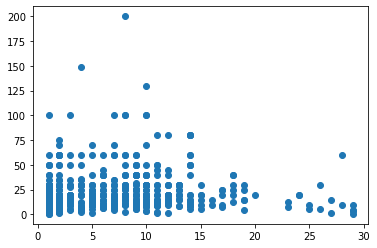

In [10]:
#number of languages against price
plt.scatter(x = 'num_lang', y='price', data = df)

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

In [ ]:
# For now we drop developer and age. We might add them again with more data
X = X.drop(columns = ['developer', 'age'])

In [ ]:
# Here we remove columns with less than 3 hits within our observations
# This is basically to remove languages with very few observations.
X = X.loc[:,X.sum(axis = 0)>3]

In [12]:
X_dev, X_test, y_dev, y_test = train_test_split(X.values, y.values, test_size = 3/10, random_state = 1)

In [16]:
from sklearn.model_selection import KFold
lambdas =  np.logspace(-4, 4, 12)
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))
MSE_lambda_lasso = []
for lambda_ in lambdas:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_Lasso = make_pipeline(StandardScaler(),
                                   PolynomialFeatures(degree = 2, include_bias = False),
                                   Lasso(alpha = lambda_, random_state = 161193))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_Lasso.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_Lasso.predict(X_val), y_val))
        
    MSE_lambda_lasso.append(np.mean(MSE_cv))

In [17]:
lambdaCV_lasso = pd.Series(MSE_lambda_lasso, index=lambdas)

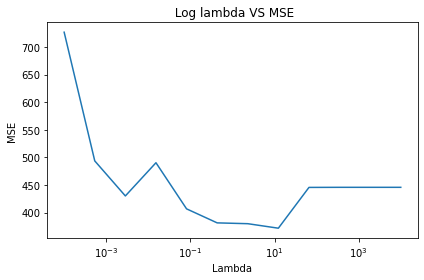

In [18]:
fig = plt.figure()
plt.xscale('log')
plt.title(' Log lambda VS MSE')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.plot(lambdaCV_lasso)
fig.tight_layout()

In [ ]:
# Now we try an Elastic Net-model with the smallest lambda found in the LASSO-model.
lambdaCV_lasso.nsmallest(1)

In [ ]:
ratio = np.linspace(0,1,10)
MSE_lambda_EN = []
for r_ in ratio:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_EN = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False),
                               StandardScaler(),
                               ElasticNet(alpha = lambdaCV_lasso.nsmallest(1).index, l1_ratio = r_, random_state = 161193))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_EN.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_EN.predict(X_val), y_val))
        
    MSE_lambda_EN.append(np.mean(MSE_cv))

In [ ]:
lambdaCV_EN = pd.Series(MSE_lambda_EN, index=ratio)

In [ ]:
fig = plt.figure()
plt.title('Elastic Net Ratio VS MSE')
plt.xlabel('Elastic Net ratio')
plt.ylabel('MSE')
plt.plot(lambdaCV_EN)
fig.tight_layout()

In [ ]:
lambdaCV_EN

In [ ]:
lambdaCV_EN.nsmallest(1).index

In [ ]:
# We see a L1 ratio of 0.111 which means our model should include 0.111 Lasso penalty and 1-0.111 Ridge penalty

In [ ]:
# Testing our models on test data
pipe_EN = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False),
                               StandardScaler(),
                               ElasticNet(alpha = lambdaCV_lasso.nsmallest(1).index,\
                                          l1_ratio = 0.1111, random_state = 161193))
pipe_EN.fit(X_dev, y_dev)

In [ ]:
mse(pipe_EN.predict(X_test), y_test)

In [ ]:
bob = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False),
                               StandardScaler(),
                               ElasticNet(alpha = lambdaCV_lasso.nsmallest(1).index,\
                                          l1_ratio = 0.5, random_state = 161193))
bob.fit(X_dev, y_dev)
mse(bob.predict(X_test), y_test)

In [ ]:
from sklearn.model_selection import validation_curve

In [ ]:
lambdas =  np.logspace(-4, 4, 12)

pipe_Lasso_2 = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), StandardScaler(), Lasso())
train_scores, test_scores = validation_curve(estimator = pipe_Lasso_2, 
                                            X = X_dev, 
                                            y = y_dev, 
                                            param_name = 'lasso__alpha',
                                            param_range = lambdas,
                                            scoring = 'neg_mean_squared_error',
                                            cv = 5)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')  

mse_score.plot(logx=True, logy=False, figsize=(10,6))

In [ ]:
mse_score

In [88]:
X

,age,developer,Arabic,Bulgarian,Czech,Danish,Dutch,English,Finnish,French,...,Intentionally Awkward Controls,Lemmings,Baseball,Tennis,Hockey,Well-Written,Hardware,Steam Machine,num_tags,time_delta
0,0,284,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,17,98
1,0,109,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,20,535
2,0,61,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,1091
3,0,140,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,1153
4,0,61,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,0,184,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,20,1124
632,0,154,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,17,3786
633,0,168,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,20,1054
634,0,178,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,11,2097


In [89]:
# from sklearn_pandas import DataFrameMapper
# import re

# #mapper = DataFrameMapper([(X.columns, StandardScaler())], df_out=True)
# #scaled_features = mapper.fit_transform(X.copy())
# #scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# feats = [key for key in X.keys() if re.match('.*feat.*',key)]
# mapper = DataFrameMapper([(X,StandardScaler())])
# X_map_scaled = mapper.fit_transform(X.copy())
# #data_test_scaled = mapper.transform(df_test)
# #data_test = df_test[feats]
# #data_train =df_train[feats]

In [90]:
X_scaled = StandardScaler().fit_transform(X)

In [92]:
X_scaled.shape

(636, 408)

In [105]:
from sklearn.decomposition import PCA

pcamodel = PCA(n_components = 408)
pcamodel.fit(X_scaled)

PCA(n_components=408)

In [106]:
eigenvalues = pcamodel.explained_variance_

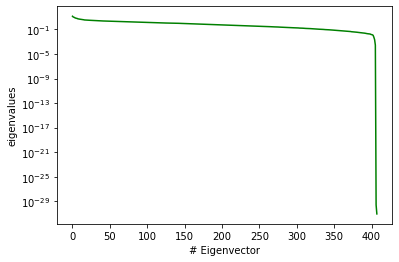

In [55]:
fig1, ax1 = plt.subplots()
ax1.plot(eigenvalues, color = 'green')
ax1.set_yscale('log')
ax1.set(xlabel = '# Eigenvector', ylabel = 'eigenvalues')
plt.show()

In [109]:
for i in range(408):
    if sum(pcamodel.explained_variance_ratio_[0:i]) >= 0.90:
        print(i)
        break

202


In [110]:
pcamodel.set_params(n_components = 202)
X_pca = pcamodel.fit_transform(X_scaled)

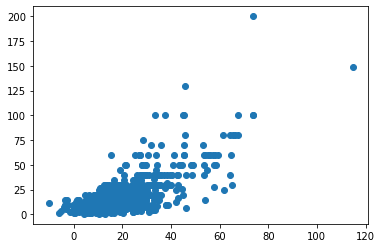

In [115]:
lr = LinearRegression()
lr.fit(X_pca, y)
plt.scatter(lr.predict(X_pca), y)

In [116]:
mse(lr.predict(X_pca), y)

191.5961025063051

In [124]:
poly_Feat = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_Feat.fit_transform(X_pca)

In [125]:
X_poly.shape

(636, 20705)

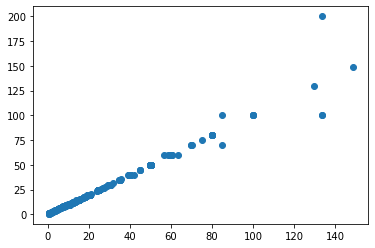

In [126]:
lr2 = LinearRegression()
lr2.fit(X_poly, y)
plt.scatter(lr2.predict(X_poly), y)

In [127]:
mse(lr2.predict(X_poly), y)

11.279550983201073

In [128]:
X_dev, X_test, y_dev, y_test = train_test_split(X.values, y.values, test_size = 3/10, random_state = 1)

In [129]:
X_dev_scaled = StandardScaler().fit_transform(X_dev)

In [130]:
pcamodel = PCA(n_components = 408)
pcamodel.fit(X_dev_scaled)

PCA(n_components=408)

In [131]:
for i in range(408):
    if sum(pcamodel.explained_variance_ratio_[0:i]) >= 0.90:
        print(i)
        break

167


In [132]:
from sklearn.model_selection import KFold
lambdas =  np.logspace(-4, 4, 12)
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))
MSE_lambda_lasso = []
for lambda_ in lambdas:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_Lasso = make_pipeline(StandardScaler(),\
                                   PCA(n_components = 167),\
                                   PolynomialFeatures(degree = 2, include_bias = False),\
                                   Lasso(alpha = lambda_, random_state = 161193))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_Lasso.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_Lasso.predict(X_val), y_val))
        
    MSE_lambda_lasso.append(np.mean(MSE_cv))

In [133]:
lambdaCV_lasso = pd.Series(MSE_lambda_lasso, index=lambdas)

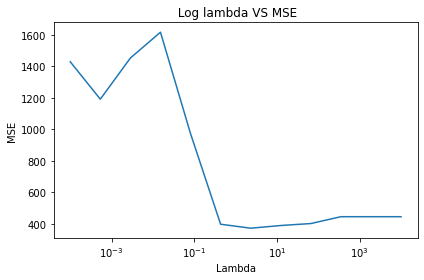

In [134]:
fig = plt.figure()
plt.xscale('log')
plt.title(' Log lambda VS MSE')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.plot(lambdaCV_lasso)
fig.tight_layout()